# URL Classification

+ https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
+ https://towardsdatascience.com/naive-bayes-classifier-from-scratch-with-python-942708211470
+ https://scikit-learn.org/stable/modules/naive_bayes.html
+ https://github.com/japborst/dart_stemmer/blob/master/lib/PorterStemmer.dart
+ https://tartarus.org/martin/PorterStemmer/
+ https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls
+ https://www.kaggle.com/datasets/akashkr/phishing-website-dataset
+ https://www.kaggle.com/datasets/sandunabeysooriya/phishing-detection-dataset
+ https://www.youtube.com/watch?v=O2L2Uv9pdDA
+ https://www.kaggle.com/code/tylersullivan/classifying-phishing-urls-three-models
+ https://towardsdatascience.com/how-i-was-using-naive-bayes-incorrectly-till-now-part-1-4ed2a7e2212b
+ https://towardsdatascience.com/why-how-to-use-the-naive-bayes-algorithms-in-a-regulated-industry-with-sklearn-python-code-dbd8304ab2cf
+ https://towardsdatascience.com/all-you-need-to-know-about-bag-of-words-and-word2vec-text-feature-extraction-e386d9ed84aa
+ https://towardsdatascience.com/text-normalization-7ecc8e084e31
+ https://medium.com/analytics-vidhya/how-to-build-a-lemmatizer-7aeff7a1208c

In [210]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.tree import export_text, plot_tree

import matplotlib.pyplot as plt
%matplotlib inline

## Data Import and Cleaning

__Features of interest:__
+ Length
+ Number of dots
+ Number of sub-paths `/`
+ Usage of shortening services
+ Usage of symbols, such as `@`, `?`, `//`
+ Using `http` or `https`
+ Domain (`.gov`, `.com`, etc.)
+ Is IP address

In [206]:
data = pd.read_csv("./data/phishing_site_urls.csv", encoding="utf-8")
data["Label"].replace(to_replace="bad", value=1, inplace=True)
data["Label"].replace(to_replace="good", value=0, inplace=True)

print(data)
# print(data.info())

                                                      URL  Label
0       nobell.it/70ffb52d079109dca5664cce6f317373782/...      1
1       www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...      1
2       serviciosbys.com/paypal.cgi.bin.get-into.herf....      1
3       mail.printakid.com/www.online.americanexpress....      1
4       thewhiskeydregs.com/wp-content/themes/widescre...      1
...                                                   ...    ...
549243                                    23.227.196.215/      1
549244                                 apple-checker.org/      1
549245                                  apple-iclods.org/      1
549246                                 apple-uptoday.org/      1
549247                                  apple-search.info      1

[549248 rows x 2 columns]


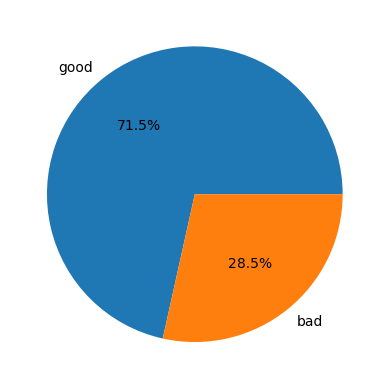

In [207]:
sizes = [data[data["Label"] == 0].shape[0]
        ,data[data["Label"] == 1].shape[0]
        ]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=["good", "bad"], autopct='%1.1f%%')
plt.show()

In [208]:
import re
from collections import Counter
from nltk.stem.porter import PorterStemmer

stem = PorterStemmer()

ip_re = re.compile(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}(:\d{1,5})?$")
url_re = re.compile(r"(https?://)?([^/]+)(/.*)?")
hexa_re = re.compile(r"^[0-9a-f]+$")
split_re = re.compile(r"[^\w\d_]")

#----------------------------#

vowels = {'a','e','i','o','u','y'}

# (assumes lowercase and w.isalpha() is True)
def readable(w: str) -> bool:
    tl, nb = 0, 0
    i, cs  = 0, 1
    while i < len(w):
        cs = 1
        v  = w[i] in vowels
        i += 1
        while i < len(w) and (w[i] in vowels) == v:
            cs += 1
            i  += 1
        if cs > 2:
           nb += 1
        tl += 1
    return (nb / tl) < 0.2

#----------------------------#
    
# Remove parsing artifacts (won't be needed for the real thing)
def cleanURL(url: str) -> str:
    s, e = 0, -1
    qs = ["'", '"']
    if url[0] in qs:
        s = 1
    if url[-1] in qs:
        e = -2
    return url[s:e]

#----------------------------#

# Split the URL into its smaller parts
def splitURL(url: str) -> tuple:
    match = url_re.match(url)
    return match.group(2,3) if match != None else None

#----------------------------#

def normalize(w: str) -> str:
    if w.isdigit():
        return '{{num}}'
    if not w.isalpha() and hexa_re.match(w) != None:
        return '{{id}}'
    if not w.isalpha():
        return '{{other}}'
    if len(w) > 4 and not readable(w):
        return '{{jnk}}'
    if len(w) > 15:
        return '{{lword}}'
    return '{{word}}'

#----------------------------#

# Extract properties and features from URL
def processURL(url: str) -> list:
    curl = cleanURL(url)
    (a, p) = splitURL(curl)
    ts = Counter([normalize(t.lower()) for t in split_re.split(a)])
    return [ curl.count('%')
           , curl.count('.')
           , curl.count('//')
           , curl.count(':')
           , curl.count('?')
           , curl.count('@')
           , int(ip_re.search(curl) != None)
           , len(curl)
           , len(split_re.split(p)) if p != None else 0
           , ts['{{id}}']
           , ts['{{jnk}}']
           , ts['{{lword}}']
           , ts['{{num}}']
           , ts['{{other}}']
           , ts['{{word}}']
           ]

#==========================================#

cs = ['%','.','//',':','?','@','ip','len','sub','{{id}}','{{jnk}}','{{lword}}','{{num}}','{{other}}','{{word}}']
vs = pd.DataFrame(data["URL"].map(processURL).to_list(), columns=cs)
        
print(vs.sample(10))

        %  .  //  :  ?  @  ip  len  sub  {{id}}  {{jnk}}  {{lword}}  {{num}}  \
308652  0  2   0  0  1  0   0   38    6       0        0          0        0   
166701  0  1   0  0  0  0   0   61    8       0        1          0        0   
537709  0  1   0  0  0  0   0   10    0       0        0          0        0   
368268  0  2   0  0  1  0   0   35    5       0        0          0        0   
151963  0  4   0  0  1  0   0   64   10       0        2          0        0   
156594  0  1   0  0  0  0   0   27    0       0        0          1        0   
520677  0  4   0  0  0  0   0   92    5       0        0          0        4   
266744  0  1   0  0  0  0   0   24    2       0        0          0        0   
525706  0  2   0  0  0  0   0   19    3       0        0          0        0   
56235   0  3   0  0  0  0   0   60    6       0        0          0        0   

        {{other}}  {{word}}  
308652          0         3  
166701          0         1  
537709          0         2  

## Training and Testing



In [200]:
trainX, testX, trainY, testY = train_test_split(vs, data.Label, test_size=0.3, random_state=42)

In [201]:
mnb = MultinomialNB()
mnb.fit(trainX, trainY)

pred = mnb.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.76      0.97      0.85    117967
         bad       0.73      0.23      0.34     46808

    accuracy                           0.76    164775
   macro avg       0.74      0.60      0.60    164775
weighted avg       0.75      0.76      0.71    164775



In [202]:
cnb = ComplementNB()
cnb.fit(trainX, trainY)

pred = cnb.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.77      0.92      0.84    117967
         bad       0.59      0.30      0.39     46808

    accuracy                           0.74    164775
   macro avg       0.68      0.61      0.61    164775
weighted avg       0.72      0.74      0.71    164775



In [203]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(trainX, trainY)

pred = dt.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.84      0.94      0.89    117967
         bad       0.79      0.56      0.66     46808

    accuracy                           0.83    164775
   macro avg       0.81      0.75      0.77    164775
weighted avg       0.83      0.83      0.82    164775



In [204]:
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
svm.fit(trainX, trainY)

pred = svm.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.78      0.97      0.86    117967
         bad       0.79      0.30      0.43     46808

    accuracy                           0.78    164775
   macro avg       0.78      0.63      0.65    164775
weighted avg       0.78      0.78      0.74    164775



---
## Post-Processing

+ Code generation
+ Other statistics

In [211]:
# r = export_text(dt, feature_names=cs)
# print(r)

plot_tree(dt)

[Text(0.8386211630783553, 0.9883720930232558, 'X[1] <= 3.5\ngini = 0.408\nsamples = 384473\nvalue = [274863, 109610]'),
 Text(0.7196831983174976, 0.9651162790697675, 'X[12] <= 0.5\ngini = 0.372\nsamples = 354269\nvalue = [266866, 87403]'),
 Text(0.6072372055141975, 0.9418604651162791, 'X[13] <= 0.5\ngini = 0.363\nsamples = 349282\nvalue = [266051, 83231]'),
 Text(0.4430485708777189, 0.9186046511627907, 'X[7] <= 150.5\ngini = 0.345\nsamples = 329064\nvalue = [256277, 72787]'),
 Text(0.16814431698119633, 0.8953488372093024, 'X[8] <= 2.5\ngini = 0.336\nsamples = 324791\nvalue = [255373, 69418]'),
 Text(0.032302392163259634, 0.872093023255814, 'X[8] <= 1.0\ngini = 0.434\nsamples = 70552\nvalue = [48102, 22450]'),
 Text(0.017600312753229222, 0.8488372093023255, 'X[14] <= 2.5\ngini = 0.234\nsamples = 33547\nvalue = [28997, 4550]'),
 Text(0.008788327927502464, 0.8255813953488372, 'X[9] <= 0.5\ngini = 0.177\nsamples = 25698\nvalue = [23175, 2523]'),
 Text(0.005148930863771, 0.8023255813953488,

Error in callback <function flush_figures at 0x0000021BF72E9040> (for post_execute):


KeyboardInterrupt: 

In [213]:
# names  = mnb.steps[0][1].get_feature_names_out()
names  = cs
values = mnb.feature_log_prob_
size   = len(cs)

rng = ""
cnt = ""

cc   = names[0][0]
low  = 0
high = 0

# Generate Code for the Flutter App
for i, n in enumerate(names):
    if cc == n[0]:
        high = i
    else:
        rng += "'{0}': Region({1}, {2}),\n".format(cc, low, high)
        low = high+1
        high = i
        cc = n[0]
    cnt += "DictEntry('{0}', {1}, {2}),\n".format(n, values[0][i], values[1][i])
rng += "'{0}': Region({1}, {2}),\n".format(cc, low, high)
    
with open("../lib/utils/url_vocabulary.dart", "w") as f:
    f.write("part of 'url_filter.dart';\n\n")
    f.write('//=================================================//\n\n')
    f.write('/// Contains the log likelihoods used to make a multinomial naive bayes prediction.\n')
    f.write('///\n')
    f.write('/// (Code generated by python script `model/url.ipynb`)\n')
    f.write("const vocabulary = Dictionary(\n")
    f.write('{')
    f.write(rng)
    f.write('},\n')
    f.write('[')
    f.write(cnt)
    f.write('],\n')
    f.write(');')